In [1]:
import os
import shutil

import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import cantera as ct
import numpy as np

from numpy import genfromtxt
from numpy import savetxt

import random as rnd
import matplotlib.pyplot as plt
from scipy import integrate 

plt.rcParams.update({'font.size': 16})
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (4,4)
%matplotlib inline
from torchdiffeq import odeint_adjoint as odeint
device = 'cpu'

base_name = 'node_h2_v1'

In [2]:
# Generate work directory
solution_data = 'sampled_multiscale_50'
work_dir = os.getcwd()
isdir = os.path.isdir(base_name) 
if isdir == False :
    os.makedirs(base_name)

n_points = 100 # number of sample points


In [3]:
# Inputs

dt = 1.E-6           # step size for inlet/outlet/pairing
tau_r  = 1.E-2       # reactor residence time
nsteps = int(tau_r / dt)

ntau_r = 5             # number of run times to simulate for
mech   = 'h2_sandiego.yaml'    # chemical mechanism

X0     = 'O2:1.0, N2:3.76'      # Oxidiser composition
X1     = 'H2:1.0'      # Fuel composition
P      = 101325.0

# eqr = np.linspace(0.5,1.5,5)
# T0     = (np.linspace(1000,1200,5)).astype(int)
eqr = [0.1, 1.1, 0.5, 1.5 ,0.25 , 1.0, 0.75, 2.0, 0.9, 1.25]
T0 = [1200,1000,1100,1050,1150,950]

n_sim = len(eqr)*len(T0)


gas = ct.Solution(mech)
nspecies = np.size(gas.species())
species = gas.species()


In [4]:
work_dir

'C:\\Users\\Asus\\Desktop\\Neural ODE with AE'

In [5]:
# make sure all cases are loaded 
print(f'eqr={eqr}\n T0 = {T0}')
for sim_id in range(1,n_sim+1):
    sim_id+1
    # print(sim_id)

eqr=[0.1, 1.1, 0.5, 1.5, 0.25, 1.0, 0.75, 2.0, 0.9, 1.25]
 T0 = [1200, 1000, 1100, 1050, 1150, 950]


In [6]:
t = np.linspace(0., tau_r, nsteps)
t = torch.tensor(t)

In [7]:
# Add Normalization and Denormalization function here , see below how they are used to recreate original systems 
def normalize(y):
    y = (y-ymin)/(ymax-ymin)   # Input Yis normalized to [0 1]
    y = np.clip(y, 0.0, 1.0) # Putting data bounds to ensure they are followed during inference
    return y

def denormalize(y): 
    # Denormalize the data
    y = y * (ymax - ymin) + ymin
    # Set negative values to zero
    y[y < 0] = 0 # Mixture fractions can not be negative
    # Ensure sum of species mass fractions is 1
    # Assuming y[1:-3] contains the species - MF of N2 = 1-sum of MF of all other species (total sum need to be 1)
    # y[:,-2] = 1.0 - np.sum(y[1:-2])
    return y

In [8]:
# This section collects all data together for all cases, initial time values are collected in t_filter variable
#----------- set the initial state
true_y_all = []
time_all = []
count = 0
for i in range(len(eqr)):
    for j in range(len(T0)):
        count += 1 
        print(f'-----------start of simulation  {count} --------------------------------------------------')
        print(f'Equivalence ration = {eqr[i]}, Temprature = {T0[j]}')
        datafile_name = solution_data +  '/const_P_solution_phi_'+str(eqr[i])+'_T0_'+str(T0[j])+'.csv'
        true_py_read = genfromtxt(datafile_name, delimiter=',')
        
        true_py = true_py_read[:,1:]
        t_filter = true_py_read[:,0]
        # timefile_name = solution_data + '/Filtered_time_phi_'+str(eqr[i])+'_T0_'+str(T0[j])+'.csv'
        # t_filter = genfromtxt(timefile_name, delimiter=',')
#         print(t_filter)
        if(count == 1):
            true_y_all = true_py
            time_all = t_filter
        else:
            true_y_all = np.concatenate((true_py,true_y_all))
            time_all = np.concatenate((t_filter,time_all))



-----------start of simulation  1 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1200
-----------start of simulation  2 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1000
-----------start of simulation  3 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1100
-----------start of simulation  4 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1050
-----------start of simulation  5 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 1150
-----------start of simulation  6 --------------------------------------------------
Equivalence ration = 0.1, Temprature = 950
-----------start of simulation  7 --------------------------------------------------
Equivalence ration = 1.1, Temprature = 1200
-----------start of simulation  8 --------------------------------------------------
Equivalence r

In [9]:
# Making sure minimum >0, not physiocally possible
true_y_all[true_y_all < 0] = 0.0 
ymax = np.max(true_y_all,axis = 0)
ymin = np.min(true_y_all,axis = 0)
ymin[-1] = 300 #setting minimum temperature to 300K
# ymin[1:-1]=0

savetxt(base_name+'/ymax_filter.csv', ymax, delimiter=',')
savetxt(base_name+'/ymin_filter.csv', ymin, delimiter=',')

ymin, ymax


(array([4.23490903e-08, 0.00000000e+00, 7.09491235e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.24460269e-01, 3.00000000e+02]),
 array([5.54628424e-02, 7.96922388e-03, 2.32317635e-01, 2.32561377e-02,
        1.77387295e-02, 2.44630848e-01, 1.85669429e-04, 2.54135007e-05,
        7.64754980e-01, 2.78080165e+03]))

In [10]:
# Scaling of solution and initial condition

true_pyn = normalize(true_y_all)
true_yn = torch.tensor(true_y_all)
true_pyn.shape

(6000, 10)

In [11]:
# These function randomize data and create batches - don't change anything here
def get_solution():
    
    start_index = (sim_id-1)*n_points
    end_index =start_index + n_points
    # print (sim_id, start_index,)
    true_y = true_pyn[start_index:end_index,:]
    true_y = torch.tensor(true_y)
    t_id =  time_all[start_index:end_index]
    
    true_y0 = true_y[0,:]
    
    t_id = torch.tensor(t_id)
    return true_y, t_id , true_y0
    
def get_batch():
    
    true_y, t_id , true_y0 = get_solution()
    s = torch.from_numpy(np.random.choice(np.arange(len(true_y) - batch_time, dtype=np.int64), batch_size, replace=False))
#     print(s)
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t_id[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y, true_y0, t_id, true_y

In [12]:
LATENT_DIM = 5  # can be tuned  for validation performance

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim=10, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, LATENT_DIM)
        )


    def forward(self, x):
        return self.encoder(x)

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, output_dim=10):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, output_dim)
        )


    def forward(self, z):
        return self.decoder(z)

# ODE Function in Latent Space
class ODEFunc(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, latent_dim)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))

    def forward(self, t, z):
        return self.net(z)

# Instantiate model components
encoder = Encoder()
decoder = Decoder()
odefunc = ODEFunc()


In [13]:
# import os
# import time
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim

# Training configuration
restart_id = 5        # New restart ID
itr = 1096            # Start from iteration 1001
epochs = 1200          # Train until 1200 epochs
batch_time = n_points - 2  # Number of timesteps in one batch
batch_size = 1         # Fixed as per instruction

# Set work directory and model base name
base_name = 'node_h2_v1'
work_dir = os.getcwd()

# Restart logic
if restart_id > 0:
    start_iter = itr
    restart_file = base_name
    os.chdir(restart_file)
    restart_model_name = restart_file + '_' + str(restart_id - 1) + '.pt'

    # Load saved model state
    checkpoint = torch.load(restart_model_name)
    encoder.load_state_dict(checkpoint['encoder'])
    odefunc.load_state_dict(checkpoint['odefunc'])
    decoder.load_state_dict(checkpoint['decoder'])
    os.chdir(work_dir)

    # Load previous losses and learning rate logs if they exist
    losses_path = os.path.join(base_name, f'Training_error_{restart_id - 1}.csv')
    lr_path = os.path.join(base_name, f'Learning_rate_{restart_id - 1}.csv')
    losses_epoch = np.loadtxt(losses_path, delimiter=',') if os.path.exists(losses_path) else np.zeros(epochs + 1)
    batch_lr = np.loadtxt(lr_path, delimiter=',') if os.path.exists(lr_path) else np.zeros((epochs + 1, 2))

    # Extend arrays to new epoch size if needed
    if losses_epoch.shape[0] < epochs + 1:
        temp_loss = np.zeros(epochs + 1)
        temp_loss[:len(losses_epoch)] = losses_epoch
        losses_epoch = temp_loss

    if batch_lr.shape[0] < epochs + 1:
        temp_lr = np.zeros((epochs + 1, 2))
        temp_lr[:len(batch_lr), :] = batch_lr
        batch_lr = temp_lr

    epoch_num = np.zeros(epochs + 1)

else:
    start_iter = 1
    losses_epoch = np.zeros(epochs + 1)
    losses_epoch[0] = 10
    epoch_num = np.zeros(epochs + 1)
    batch_lr = np.zeros([epochs + 1, 2])

# Optimizer and scheduler
learning_rate = 0.0001
all_params = list(encoder.parameters()) + list(odefunc.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(all_params, lr=learning_rate)
loss_function = nn.L1Loss()
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000], gamma=0.5)

start = time.time()

# Function to get batch of training data
def get_batch():
    true_y, t_id, true_y0 = get_solution()
    available_points = len(true_y) - batch_time
    effective_batch_size = min(batch_size, available_points)

    s = torch.from_numpy(
        np.random.choice(
            np.arange(available_points, dtype=np.int64),
            effective_batch_size,
            replace=False
        )
    )

    batch_y0 = true_y[s]  # (M, D)
    batch_t = t_id[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y, true_y0, t_id, true_y

# === Training loop ===
for itr in range(start_iter, epochs + 1):
    loss_sim = np.zeros(n_sim)

    for sim_id in range(1, n_sim + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y, true_y0, t_id, true_y = get_batch()

        z0 = encoder(batch_y0.float())
        pred_z = odeint(odefunc, z0, batch_t.float(), atol=1e-8, rtol=1e-7, method='dopri5')
        pred_y = torch.stack([decoder(z) for z in pred_z], dim=0)

        loss = torch.mean(loss_function(pred_y.float(), batch_y.float()))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(all_params, max_norm=1.0)
        optimizer.step()

        loss_sim[sim_id - 1] = loss.item()

    mean_loss_iter = np.mean(loss_sim)
    scheduler.step(mean_loss_iter)

    lr_c = optimizer.param_groups[0]['lr']
    batch_lr[itr, 0] = lr_c
    batch_lr[itr, 1] = mean_loss_iter

    pos_index = losses_epoch > 0
    min_loss = min(losses_epoch[pos_index])

    print('Training Iter {:04d} | Loss {:.8f} | LR = {:.8f}'.format(itr, mean_loss_iter, lr_c))
    losses_epoch[itr] = mean_loss_iter
    epoch_num[itr] = itr - 1

    if mean_loss_iter < min_loss:
        os.chdir(base_name)
        model_name = f"{base_name}_{restart_id}.pt"
        torch.save({
            'encoder': encoder.state_dict(),
            'odefunc': odefunc.state_dict(),
            'decoder': decoder.state_dict()
        }, model_name)

        model_name_short = f"{base_name}short_{restart_id}.pt"
        torch.save({
            'encoder': encoder.state_dict(),
            'odefunc': odefunc.state_dict(),
            'decoder': decoder.state_dict()
        }, model_name_short)
        os.chdir(work_dir)

        savetxt(f"{base_name}/Training_error_{restart_id}.csv", losses_epoch, delimiter=',')
        savetxt(f"{base_name}/Learning_rate_{restart_id}.csv", batch_lr, delimiter=',')

end = time.time()
print(f'Total training time = {end - start:.2f} seconds')


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Iter 1096 | Loss 0.01495865 | LR = 0.00010000
Training Iter 1097 | Loss 0.01459247 | LR = 0.00010000
Training Iter 1098 | Loss 0.01475256 | LR = 0.00010000
Training Iter 1099 | Loss 0.01467338 | LR = 0.00010000
Training Iter 1100 | Loss 0.01462006 | LR = 0.00010000
Training Iter 1101 | Loss 0.01498506 | LR = 0.00010000
Training Iter 1102 | Loss 0.01469316 | LR = 0.00010000
Training Iter 1103 | Loss 0.01493166 | LR = 0.00010000
Training Iter 1104 | Loss 0.01485195 | LR = 0.00010000
Training Iter 1105 | Loss 0.01449490 | LR = 0.00010000
Training Iter 1106 | Loss 0.01471604 | LR = 0.00010000
Training Iter 1107 | Loss 0.01476598 | LR = 0.00010000
Training Iter 1108 | Loss 0.01470011 | LR = 0.00010000
Training Iter 1109 | Loss 0.01467781 | LR = 0.00010000
Training Iter 1110 | Loss 0.01490846 | LR = 0.00010000
Training Iter 1111 | Loss 0.01444558 | LR = 0.00010000
Training Iter 1112 | Loss 0.01438394 | LR = 0.00010000
Training Iter 1113 | Loss 0.01467693 | LR = 0.00010000
Training I

KeyboardInterrupt: 

In [14]:
os.makedirs(base_name, exist_ok=True)
os.chdir(base_name)

# Save complete modules
torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(odefunc.state_dict(), 'odefunc.pt')
torch.save(decoder.state_dict(), 'decoder.pt')

# Save training error logs (corrected path)
savetxt('Training_error.csv', losses_epoch, delimiter=',')

# Save learning rate progression (corrected path)
savetxt('Learning_rate.csv', batch_lr, delimiter=',')

os.chdir(work_dir)


In [15]:
z0 = encoder(true_y0.float())
pred_z = odeint(odefunc, z0, batch_t.float(), atol=1e-7, rtol=1e-6, method='dopri5')
pred_y = decoder(pred_z)

py_predict_standard = pred_y.detach().numpy()
py_predict = denormalize(py_predict_standard)


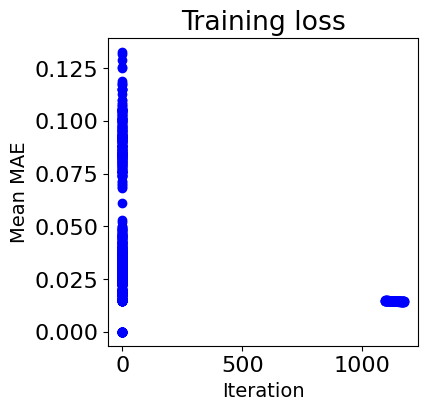

In [16]:
plt.plot(epoch_num[2:], losses_epoch[2:], 'ob')
plt.title('Training loss')
plt.xlabel(r'Iteration', fontsize=14)
plt.ylabel(r'Mean MAE', fontsize=14)

fig_name = base_name + "_Training Loss"
plt.savefig(f"{fig_name}.png")  # Save first
plt.show()                      # Then show


In [17]:
def plot_species_compare(t, my_data, t_2, my_data_2, filename):
    col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime', 'coral']
    plt.figure(figsize=(12, 4))  # Optional: clearer plots
    
    for k in range(nspecies):
        plt.plot(t, my_data[:, k], color=col[k], label=species[k])  # Original
    
    for k in range(nspecies):
        plt.plot(t_2, my_data_2[:, k], '--o', color=col[k])  # Prediction
    
    plt.xlabel(r'time (sec)', fontsize=14)
    plt.ylabel(r'Species Mass Fraction', fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1.0e-16, 1.0])
    plt.xlim([1.0e-6, 0.01])
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.75, 1.0))
    
    fig_name = base_name + "/SpeciesMF_" + filename + '.png'
    plt.tight_layout()
    plt.savefig(fig_name, dpi=300)
    plt.show()


In [18]:
def plot_temp_compare(t, my_data, t_2, my_data_2, filename):
    plt.figure(figsize=(12, 4))
    plt.plot(t, my_data[:, -1], '-b', label='True')
    plt.plot(t_2, my_data_2[:, -1], '--or', label='Predicted')

    plt.xlabel(r'time (sec)', fontsize=14)
    plt.ylabel(r'Temperature (K)', fontsize=14)
    plt.xscale('log')
    plt.ylim([900, 2800])
    plt.xlim([1.0e-6, 0.01])
    
    plt.legend()
    
    fig_name = base_name + "/Temp_" + filename + '.png'
    plt.tight_layout()
    plt.savefig(fig_name, dpi=300)
    plt.show()


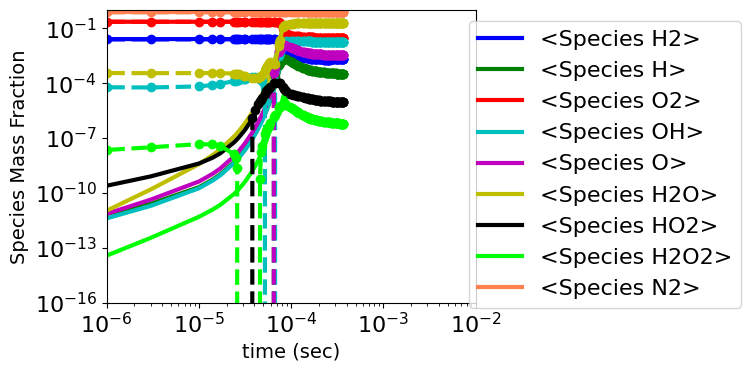

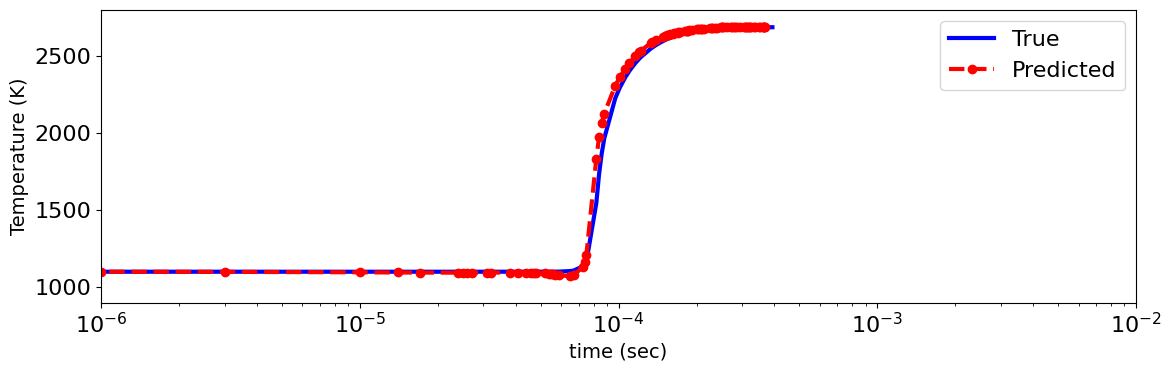

In [19]:
# Easy case (Validation)
sim_id = 10
filename = str(sim_id) + 'short_t'
batch_y0, batch_t, batch_y, true_y0, t_id, true_y = get_batch()
true_y = denormalize(true_y)

# Encode the true_y0 to latent space
z0 = encoder(true_y0.float())

# Predict in latent space
pred_z = odeint(odefunc, z0, batch_t.float(), atol=1e-10, rtol=1e-6)

# Decode predictions
pred_y = torch.stack([decoder(z) for z in pred_z], dim=0)

# Denormalize prediction
py_predict_standard = pred_y.detach().numpy()
py_predict = denormalize(py_predict_standard)

# Plot
plot_species_compare(t_id, true_y, batch_t, py_predict, filename)
plot_temp_compare(t_id, true_y, batch_t, py_predict, filename)


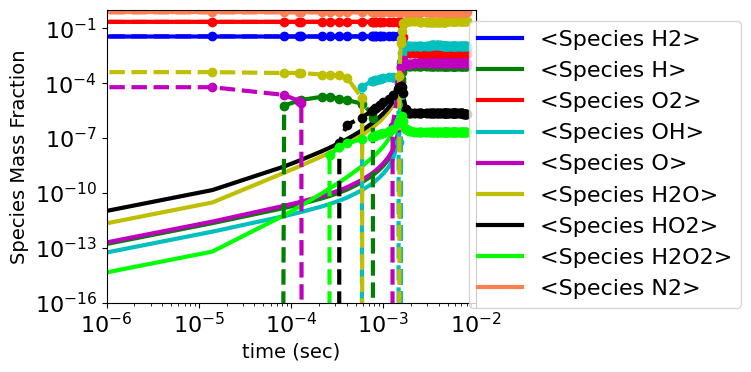

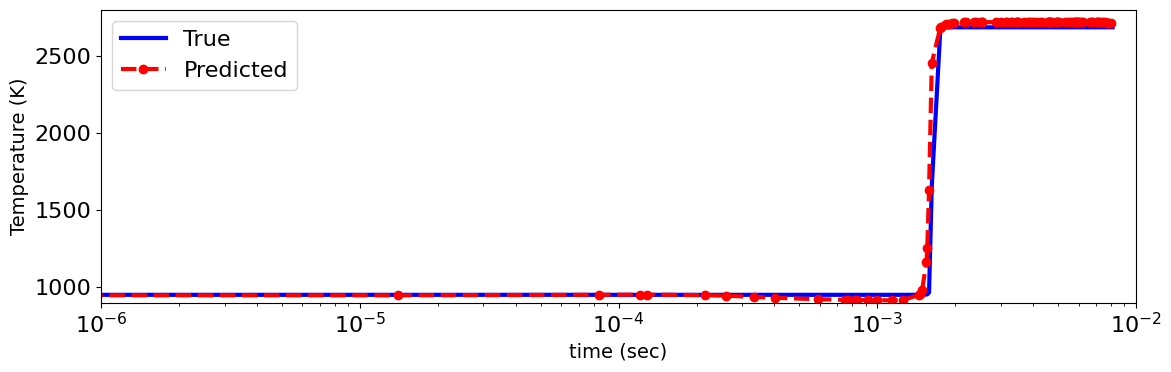

In [20]:
# Difficult case
sim_id = 1
filename = str(sim_id) + 'full_t'

# Get the batch and true trajectory
batch_y0, batch_t, batch_y, true_y0, t_id, true_y = get_batch()
true_y = denormalize(true_y)

# Encode the true initial condition into latent space
z0 = encoder(true_y0.float())

# Solve in latent space
pred_z = odeint(odefunc, z0, batch_t.float(), atol=1e-10, rtol=1e-6)

# Decode predicted latent states to physical states
pred_y = torch.stack([decoder(z) for z in pred_z], dim=0)

# Convert to numpy and denormalize
py_predict_standard = pred_y.detach().numpy()
py_predict = denormalize(py_predict_standard)

# Plot species and temperature comparisons
plot_species_compare(t_id, true_y, batch_t, py_predict, filename)
plot_temp_compare(t_id, true_y, batch_t, py_predict, filename)
